In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
def nice_plot(ax):
    ax.set(xlabel="$x$", ylabel="$y$")
    ax.axhline(0, color="black")
    ax.axvline(0, color="black")
    ax.grid(alpha=0.5)

### 7.1 Early stopping
The purpose of this exercise is to see how splitting up the available data in training, validation, and test data can help the fitting procedure becoming more reliable.

In [3]:
np.random.seed(1)
parabola = lambda x: 0.1*x**2 - 0.5*x - 6
xs_plot = torch.linspace(-10, 10, 100)
xs = torch.tensor(np.random.uniform(-10, 10, 50), dtype=torch.float32)
ys = parabola(xs) + 1.5*torch.randn_like(xs)

xs_train, ys_train = xs[:40], ys[:40]
xs_validation, ys_validation = xs[40:45], ys[40:45]
xs_test, ys_test = xs[45:], ys[45:]

### 7.2 Plot the data
Wrap your data as PyTorch `Dataset`'s and let them be handled by PyTorch `DataLoader`'s. Plot the three datasets with loops like this:

In [4]:
# for data in loader:
#     ax.scatter(data[0], data[1])

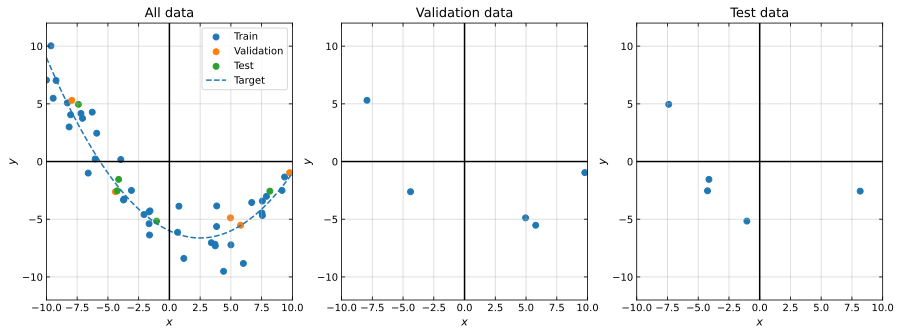

In [5]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class MyDataset(Dataset):
    def __init__(self, xs, ys):
        self.xs = xs
        self.ys = ys
    def __len__(self):
        return len(self.xs)
    def __getitem__(self, i):
        return self.xs[i], self.ys[i]

train_data = MyDataset(xs_train, ys_train)
validation_data = MyDataset(xs_validation, ys_validation)
test_data = MyDataset(xs_test, ys_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for data in train_loader:
    axs[0].scatter(data[0], data[1], label="Train")
    axs[0].set_title("All data")
for data in validation_loader:
    axs[0].scatter(data[0], data[1], label="Validation")
    axs[1].scatter(data[0], data[1])
    axs[1].set_title("Validation data")
for data in test_loader:
    axs[0].scatter(data[0], data[1], label="Test")
    axs[2].scatter(data[0], data[1])
    axs[2].set_title("Test data")

axs[0].plot(xs_plot, parabola(xs_plot), ls="--", label="Target")
axs[0].legend()
for ax in axs:
    nice_plot(ax)
    ax.set(xlim=[-10,10], ylim=[-12,12])

fig.savefig('ex53_fig1.png')

### 7.3 Early stopping
Implement early stopping and plot the training and validation errors. Here it is done for two different values of how many times the validation loss fails to improve before stopping is triggered.

In [6]:
class DeepModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1, 128),
            torch.nn.SiLU(),
            torch.nn.Linear(128, 128),
            torch.nn.SiLU(),
            torch.nn.Linear(128, 128),
            torch.nn.SiLU(),
            torch.nn.Linear(128, 1)
        )

    def forward(self, x):
        x = x.view(-1, 1)
        return self.layers(x)

class EarlyStopping:
    def __init__(self, patience=5):
        # patience (int): How many epochs to wait after last time validation loss improved.
        self.patience = patience
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
early_stopping = EarlyStopping(patience=3)

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Jakob\anaconda3\envs\COMPHY\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Jakob\anaconda3\envs\COMPHY\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 13%|█▎        | 132/1000 [00:00<00:04, 211.32it/s]


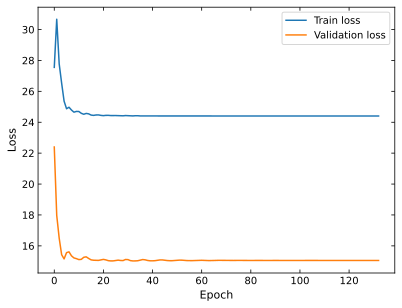

In [7]:
# Let's do a proper training loop with early stopping
model = DeepModel()
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=100)

train_losses = []
val_losses = []
for epoch in tqdm(range(1000)):
    model.train()
    train_loss = 0.0
    for batch_of_data in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_of_data[0])
        loss_value = loss(outputs, batch_of_data[1])
        loss_value.backward()
        optimizer.step()
        train_loss += loss_value.item() * batch_of_data[0].size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    for batch_of_data in validation_loader:
        with torch.no_grad():
            outputs = model(batch_of_data[0])
            val_loss += loss(outputs, batch_of_data[1]).item() * batch_of_data[0].size(0)
    val_loss /= len(validation_loader.dataset)
    val_losses.append(val_loss)
    early_stopping(val_loss)
    if early_stopping.early_stop:
        break

fig, ax = plt.subplots()
ax.plot(train_losses, label="Train loss")
ax.plot(val_losses, label="Validation loss")
ax.set(xlabel="Epoch", ylabel="Loss")
ax.legend()

fig.savefig('ex53_fig2.png')

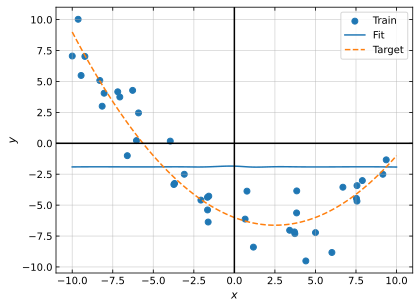

In [8]:
# Plot training data only, target function, and fitted curve
fig, ax = plt.subplots()
ax.scatter(xs_train, ys_train, label="Train")
ax.plot(xs_plot, model(xs_plot).detach(), label="Fit")
ax.plot(xs_plot, parabola(xs_plot), ls="--", label="Target")
ax.legend()
nice_plot(ax)

fig.savefig('ex53_fig3.png')

### 7.4 More data
Repeat the exercise with larger datasets

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Jakob\anaconda3\envs\COMPHY\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Jakob\anaconda3\envs\COMPHY\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Jakob\anaconda3\envs\COMPHY\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results d

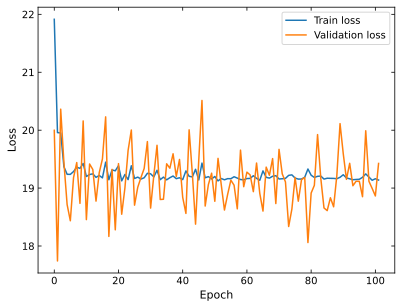

In [9]:
np.random.seed(2)
xs_plot = torch.linspace(-10, 10, 100)
xs = torch.tensor(np.random.uniform(-10, 10, 500), dtype=torch.float32)
ys = parabola(xs) + 1.5*torch.randn_like(xs)

xs_train, ys_train = xs[:400], ys[:400]
xs_validation, ys_validation = xs[400:450], ys[400:450]
xs_test, ys_test = xs[450:], ys[450:]

train_data = MyDataset(xs_train, ys_train)
validation_data = MyDataset(xs_validation, ys_validation)
test_data = MyDataset(xs_test, ys_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

model = DeepModel()
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
early_stopping = EarlyStopping(patience=100)

train_losses = []
val_losses = []
for epoch in tqdm(range(1000)):
    model.train()
    train_loss = 0.0
    for batch_of_data in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_of_data[0])
        loss_value = loss(outputs, batch_of_data[1])
        loss_value.backward()
        optimizer.step()
        train_loss += loss_value.item() * batch_of_data[0].size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    for batch_of_data in validation_loader:
        with torch.no_grad():
            outputs = model(batch_of_data[0])
            val_loss += loss(outputs, batch_of_data[1]).item() * batch_of_data[0].size(0)
    val_loss /= len(validation_loader.dataset)
    val_losses.append(val_loss)
    early_stopping(val_loss)
    if early_stopping.early_stop:
        break

fig, ax = plt.subplots()
ax.plot(train_losses, label="Train loss")
ax.plot(val_losses, label="Validation loss")
ax.set(xlabel="Epoch", ylabel="Loss")
ax.legend()

fig.savefig('ex53_fig4.png')

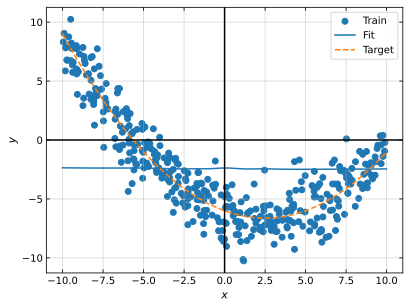

In [10]:
# Plot training data only, target function, and fitted curve
fig, ax = plt.subplots()
ax.scatter(xs_train, ys_train, label="Train")
ax.plot(xs_plot, model(xs_plot).detach(), label="Fit")
ax.plot(xs_plot, parabola(xs_plot), ls="--", label="Target")
ax.legend()
nice_plot(ax)

fig.savefig('ex53_fig5.png')